In [1]:
path = r"/Users/constantinslioussarenko/PythonGitRepositories/MyoMap"
sys.path.append(path+"/epgpy")
sys.path.append(path+"/machines")
sys.path.append(path+"/mutools")
sys.path.append(path+"/dicomstack")
sys.path.append(path+"/mrf-sim")

#import matplotlib
#matplotlib.use("TkAgg")
from mrfsim import T1MRF
from image_series import *
from utils_mrf import *
import json
from finufft import nufft1d1,nufft1d2
from scipy import signal,interpolate
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import numpy as np
from movements import *
from dictoptimizers import *
from toy_model_keras import *
import tensorflow as tf
%matplotlib inline
## Random map simulation


class PerformancePlotCallback(keras.callbacks.Callback):
    def __init__(self, x_test, y_test):
        self.x = x_test
        self.y = y_test

    def on_train_batch_end(self, epoch, logs=None):
        #print('Evaluating Model...')
        x = self.x.reshape(1,-1)
        #print(x.shape)
        pred = self.model.predict(x)
        Y_pred=optimizer.paramDict["output_scaler"].inverse_transform(pred.reshape(1,-1))

        global predictions

        predictions.append(Y_pred[0])

        #print("=====Parameters comparison===========")
        # print("Index : {}".format(i))
        # print("wT1 : {} vs {}".format(Y_pred[0][0], self.y[0]))
        # print("fT1 : {} vs {}".format(Y_pred[0][1], self.y[1]))
        # print("attB1 : {} vs {}".format(Y_pred[0][2], self.y[2]))
        # print("df : {} vs {}".format(Y_pred[0][3], self.y[3]))
        # print("ff : {} vs {}".format(Y_pred[0][4], self.y[4]))

        #print('Model Evaluation: ', self.model.evaluate(self.x_test))

I was here


/Users/constantinslioussarenko/opt/anaconda3/envs/MRF/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [58]:

useGPU=False

dictfile = "../mrf175.dict"
#dictfile = "mrf175_CS.dict"
dictfile = "../mrf175_SimReco2_light.dict"

with open("../mrf_sequence.json") as f:
    sequence_config = json.load(f)


seq = T1MRF(**sequence_config)

window = 8 #corresponds to nspoke by image
size=(256,256)

file_matlab_paramMap = "../data/Phantom1/paramMap.mat"

###### Building Map
#m = MapFromFile("TestPhantomV1",image_size=size,file=file_matlab_paramMap,rounding=True)

with open("../mrf_dictconf_SimReco2.json") as f:
    dict_config = json.load(f)

dict_config["ff"]=np.arange(0.,1.05,0.05)

window = 8 #corresponds to nspoke by image
region_size=16 #size of the regions with uniform values for params in pixel number (square regions)
size=(256,256)



file_matlab_paramMap = "../data/paramMap.mat"

###### Building Map
m = RandomMap("TestRandom",dict_config,image_size=size,region_size=region_size,mask_reduction_factor=1/4)

m.buildParamMap()

#m.plotParamMap(save=True)

##### Simulating Ref Images
m.build_ref_images(seq)

ntimesteps=175
nspoke=8
npoint = 2*m.images_series.shape[1]

radial_traj=Radial(total_nspokes=ntimesteps*nspoke,npoint=npoint)
kdata = m.generate_kdata(radial_traj,useGPU=useGPU)

volumes = simulate_radial_undersampled_images(kdata,radial_traj,m.image_size,density_adj=True,useGPU=useGPU)
mask = build_mask_single_image(kdata,radial_traj,m.image_size,useGPU=useGPU)#Not great - lets make both simulate_radial_.. and build_mask_single.. have kdata as input and call generate_kdata upstream


Building Param Map
Building Ref Images
Simulating Water Signal
Simulating Fat Signal
Build dictionary.
Building image series
Image series built
Generating kdata


In [59]:
FF_list = list(np.arange(0., 1.05, 0.05))
keys, signal = read_mrf_dict(dictfile, FF_list)
Y_TF = np.array(keys)

#signal=signal/np.expand_dims(np.linalg.norm(signal,axis=-1),axis=-1)
real_signal = signal.real
imag_signal = signal.imag

#real_signal=real_signal/np.expand_dims(np.linalg.norm(real_signal,axis=-1),axis=-1)
#imag_signal=imag_signal/np.expand_dims(np.linalg.norm(imag_signal,axis=-1),axis=-1)

X_TF = np.concatenate((real_signal, imag_signal), axis=1)
#X_TF = X_TF/np.expand_dims(np.linalg.norm(X_TF,axis=-1),axis=-1)


In [60]:
X_TF.shape

(18144, 350)

In [61]:
Y_TF[0]

array([5.5e+02, 3.0e+02, 3.0e-01, 6.0e-02, 0.0e+00])

(array([1728., 1728., 1728., 1728., 1728., 1728., 1728., 1728., 1728.,
        2592.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

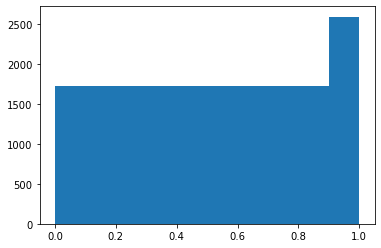

In [62]:
plt.hist(Y_TF[:,4])

In [63]:
X_TF.shape

(18144, 350)

In [64]:
df=pd.DataFrame(Y_TF)

In [65]:
df.describe()

,0,1,2,3,4
count,18144.000000,18144.0,18144.000000,1.814400e+04,18144.000000
mean,1100.000000,300.0,0.650000,-9.790326e-20,0.500000
std,474.793735,0.0,0.229135,3.873090e-02,0.302773
min,550.000000,300.0,0.300000,-6.000000e-02,0.000000
25%,687.500000,300.0,0.475000,-3.000000e-02,0.250000
50%,950.000000,300.0,0.650000,-0.000000e+00,0.500000
75%,1450.000000,300.0,0.825000,3.000000e-02,0.750000
max,2000.000000,300.0,1.000000,6.000000e-02,1.000000


In [66]:

callbacks_list = []
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


i=np.random.choice(X_TF.shape[0])
perf_callback = PerformancePlotCallback(X_TF[i],Y_TF[i])

predictions=[]

callbacks_list.append(tensorboard_callback)
callbacks_list.append(stop_early)
#callbacks_list.append(perf_callback)

2022-03-28 18:28:48.882872: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-03-28 18:28:48.882889: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-03-28 18:28:48.883272: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [67]:
log_dir

'logs/fit/20220328-182848'

In [68]:
def my_loss_fn(y_true, y_pred,weights):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`


In [69]:
def build_and_compile_model_simple(n_outputs,loss="mean_squared_error",loss_weights=None,optimizer=tf.keras.optimizers.Adam(lr=0.01)):
    model = keras.Sequential([
        layers.Dense(1000, activation="relu", name="Dense_1"),
        layers.Dense(400, activation="relu", name="Dense_2"),
        layers.Dense(50, activation="relu", name="Dense_3"),
        layers.Dense(30, activation="relu", name="Dense_4"),
        layers.Dense(30, activation="relu", name="Dense_5"),
        layers.Dense(n_outputs,activation="sigmoid",name="Dense_Out"),
    ])
    #print(**optimizer_params)
    model.compile(loss=loss,
                  optimizer=optimizer,loss_weights=loss_weights)
    return model

/Users/constantinslioussarenko/opt/anaconda3/envs/MRF/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [70]:
X_TF.shape

(18144, 350)

In [71]:

model = build_and_compile_model_simple
fitting_opt = {
"batch_size":256*4,"shuffle":True,
    "validation_split":0.2,
    "verbose":1, "epochs":300,"callbacks":callbacks_list

}


lr = 0.1
momentum=0.8
epochs=int(X_TF.shape[0]/fitting_opt["batch_size"])
decay_rate=lr/epochs

#optimizer = ToyNN(model,fitting_opt,model_opt={"lr":0.1,"loss_weights":[1.,1.,10.,10.,10.]},mask=mask)
#optimizer = ToyNN(model,fitting_opt,model_opt={"lr":0.01,"loss_weights":[1.,1.,10.,10.,10.]},mask=mask)
NN_search = ToyNN(model,fitting_opt,model_opt={"optimizer":tf.keras.optimizers.SGD(learning_rate=0.1),"loss_weights":[1.,1.,10.,10.,10.]},mask=mask)
NN_search = ToyNN(model,fitting_opt,input_scaler=None,model_opt={"optimizer":tf.keras.optimizers.SGD(learning_rate=lr,decay=decay_rate,momentum=momentum),"loss_weights":[10.,1.,1.,1.,5.]},mask=mask)


#optimizer = ToyNN(model,fitting_opt,model_opt={},mask=mask)



In [72]:
epochs

17

In [73]:
NN_search.fit_and_set(dictfile)

predictions=np.array(predictions)

(18144, 350)
(18144, 5)
5
Epoch 1/300
13/15 [=========================>....] - ETA: 0s - loss: 0.8873

2022-03-28 18:28:55.890554: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-03-28 18:28:55.890569: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-03-28 18:28:55.929499: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-03-28 18:28:55.930341: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-03-28 18:28:55.931851: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20220328-182848/train/plugins/profile/2022_03_28_18_28_55
2022-03-28 18:28:55.933240: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/fit/20220328-182848/train/plugins/profile/2022_03_28_18_28_55/constantins-MacBook-Pro.local.trace.json.gz
2022-03-28 18:28:55.934675: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20220328-182

15/15 [==============================] - 1s 23ms/step - loss: 0.8690 - val_loss: 1.5452
Epoch 2/300
15/15 [==============================] - 0s 13ms/step - loss: 0.5997 - val_loss: 1.3271
Epoch 3/300
15/15 [==============================] - 0s 13ms/step - loss: 0.4866 - val_loss: 1.2547
Epoch 4/300
15/15 [==============================] - 0s 16ms/step - loss: 0.4343 - val_loss: 1.1725
Epoch 5/300
15/15 [==============================] - 0s 15ms/step - loss: 0.3498 - val_loss: 1.0897
Epoch 6/300
15/15 [==============================] - 0s 13ms/step - loss: 0.3180 - val_loss: 1.0870
Epoch 7/300
15/15 [==============================] - 0s 16ms/step - loss: 0.3072 - val_loss: 1.0544
Epoch 8/300
15/15 [==============================] - 0s 14ms/step - loss: 0.2937 - val_loss: 1.0485
Epoch 9/300
15/15 [==============================] - 0s 15ms/step - loss: 0.2666 - val_loss: 1.0221
Epoch 10/300
15/15 [==============================] - 0s 14ms/step - loss: 0.2170 - val_loss: 0.9778
Epoch 11/30

15/15 [==============================] - 0s 14ms/step - loss: 0.0444 - val_loss: 0.2958
Epoch 83/300
15/15 [==============================] - 0s 13ms/step - loss: 0.0442 - val_loss: 0.3002
Epoch 84/300
15/15 [==============================] - 0s 13ms/step - loss: 0.0435 - val_loss: 0.3194
Epoch 85/300
15/15 [==============================] - 0s 14ms/step - loss: 0.0433 - val_loss: 0.2807
Epoch 86/300
15/15 [==============================] - 0s 15ms/step - loss: 0.0429 - val_loss: 0.3101
Epoch 87/300
15/15 [==============================] - 0s 15ms/step - loss: 0.0425 - val_loss: 0.2729
Epoch 88/300
15/15 [==============================] - 0s 13ms/step - loss: 0.0423 - val_loss: 0.3026
Epoch 89/300
15/15 [==============================] - 0s 13ms/step - loss: 0.0418 - val_loss: 0.2577
Epoch 90/300
15/15 [==============================] - 0s 14ms/step - loss: 0.0420 - val_loss: 0.2657
Epoch 91/300
15/15 [==============================] - 0s 13ms/step - loss: 0.0414 - val_loss: 0.2881
Epo

In [74]:
j=np.random.choice(X_TF.shape[0])
print(j)
print(Y_TF[j])

12872
[1.4e+03 3.0e+02 7.0e-01 6.0e-02 1.0e+00]


In [75]:
if NN_search.paramDict["input_scaler"] is not None:
    x=NN_search.paramDict["input_scaler"].transform(X_TF[j].reshape(1,-1))
else:
    x=X_TF[j].reshape(1,-1)
NN_search.paramDict["output_scaler"].inverse_transform(NN_search.paramDict["model"].predict(x))

array([[8.7627533e+02, 3.0000500e+02, 7.2927994e-01, 5.5491015e-02,
        9.2337090e-01]], dtype=float32)

In [76]:
k=j-20
print(k)
print(Y_TF[k])

12852
[1.4e+03 3.0e+02 7.0e-01 6.0e-02 0.0e+00]


In [77]:
if NN_search.paramDict["input_scaler"] is not None:
    X=NN_search.paramDict["input_scaler"].transform(X_TF)
else:
    X=X_TF
Y_pred=NN_search.paramDict["output_scaler"].inverse_transform(NN_search.paramDict["model"].predict(X))


In [78]:
X.shape

(18144, 350)

In [79]:
df_errors = pd.DataFrame(np.abs(Y_pred-Y_TF),columns=["wT1","fT1","attB1","df","ff"])

df_errors.mean()

wT1      187.127367
fT1        0.002339
attB1      0.031520
df         0.002950
ff         0.030614
dtype: float64

In [80]:
df_errors.describe()

,wT1,fT1,attB1,df,ff
count,18144.000000,18144.000000,18144.000000,1.814400e+04,18144.000000
mean,187.127367,0.002339,0.031520,2.949744e-03,0.030614
std,208.039704,0.001452,0.022301,2.928587e-03,0.024550
min,0.002625,0.000366,0.000003,2.968311e-07,0.000001
25%,45.807556,0.001221,0.011455,7.793811e-04,0.012607
50%,109.428894,0.001923,0.029029,1.977220e-03,0.025733
75%,252.183716,0.003143,0.048797,4.219837e-03,0.041226
max,1273.780029,0.006958,0.190361,2.052418e-02,0.250361


/var/folders/9d/8j76mh7d60gchtycg8syxcn00000gn/T/ipykernel_60278/1028100267.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_errors.hist(bins=20,ax=ax);


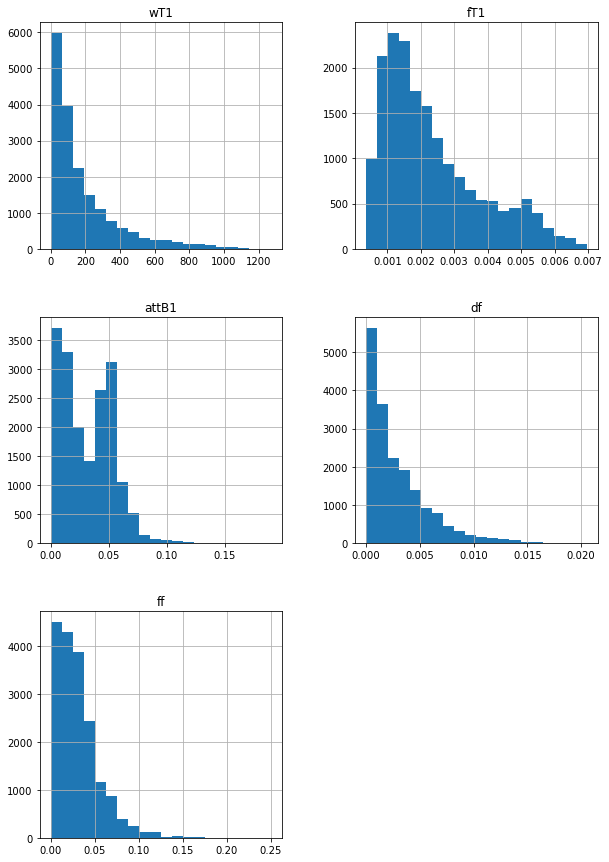

In [81]:
fig=plt.figure(figsize=(10,15));
ax = fig.gca()
df_errors.hist(bins=20,ax=ax);

In [25]:
plt.plot(X_TF[k])
plt.plot(X_TF[j])

NameError: name 'k' is not defined

In [27]:
#for j in range(Y_TF.shape[1]):
#    plt.figure()
#    plt.plot(predictions[10:,j])
#    plt.axhline(y=Y_TF[i,j],c="r",linestyle="dashed")
#

In [82]:
#volumes=volumes/np.linalg.norm(volumes,axis=0)
all_maps_adj=NN_search.search_patterns(dictfile,volumes)



(16383, 350)


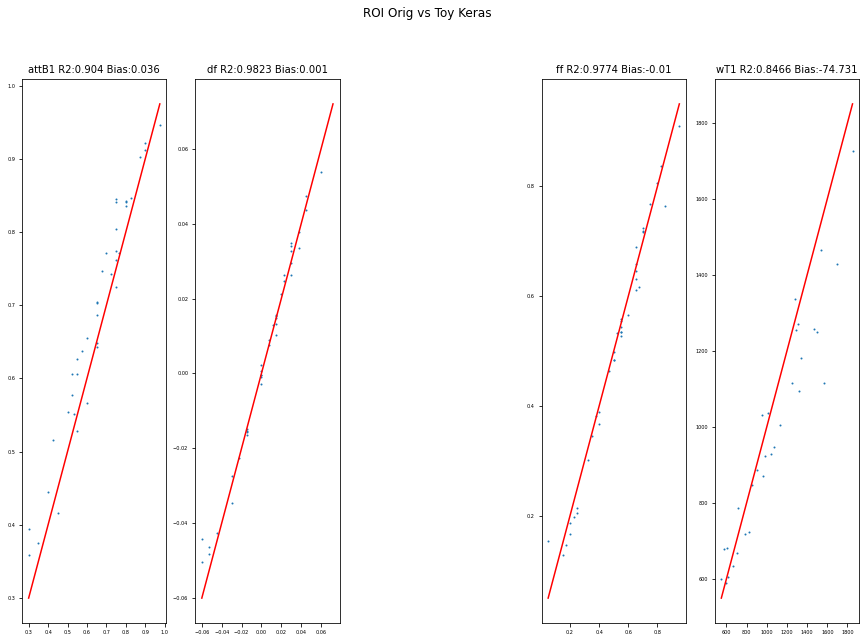

In [83]:

maskROI=buildROImask(m.paramMap)
regression_paramMaps_ROI(m.paramMap, all_maps_adj[0][0], m.mask > 0, all_maps_adj[0][1] > 0,maskROI=maskROI,
                             title="ROI Orig vs Toy Keras", proj_on_mask1=True, adj_wT1=True, fat_threshold=0.7)


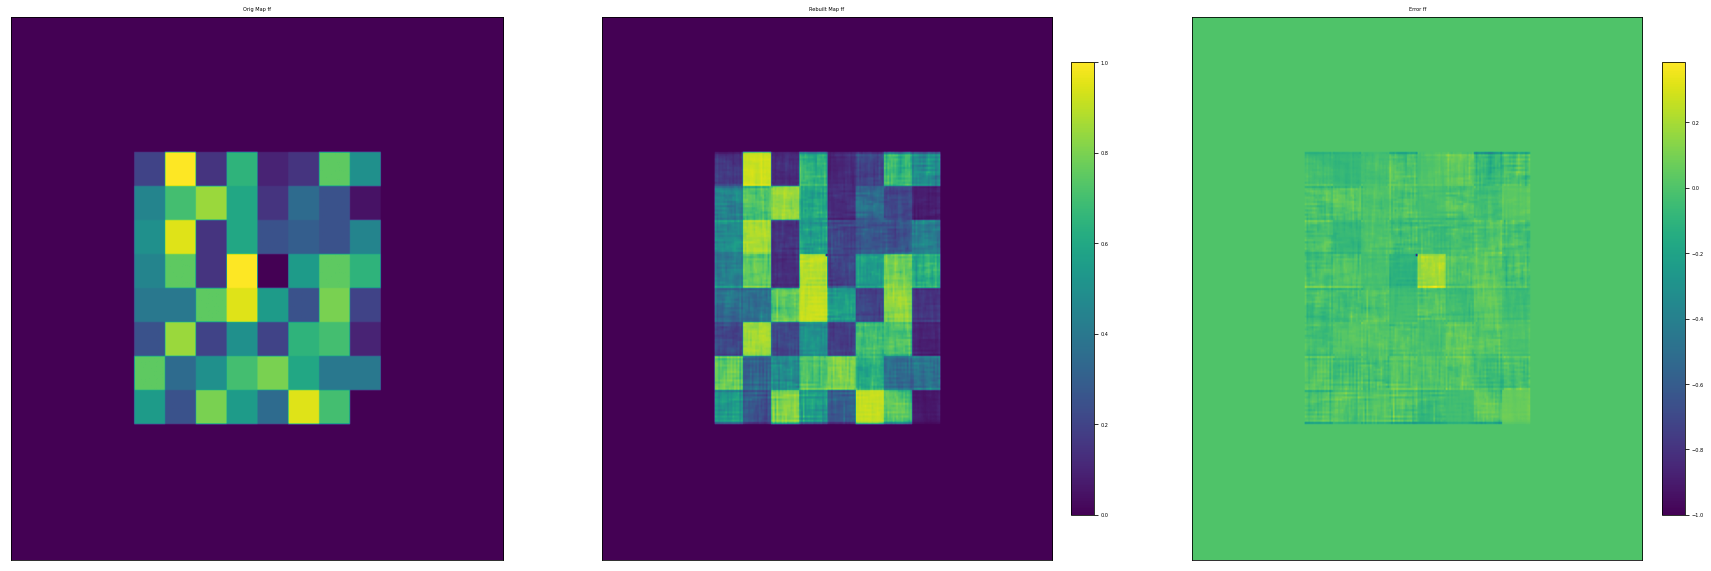

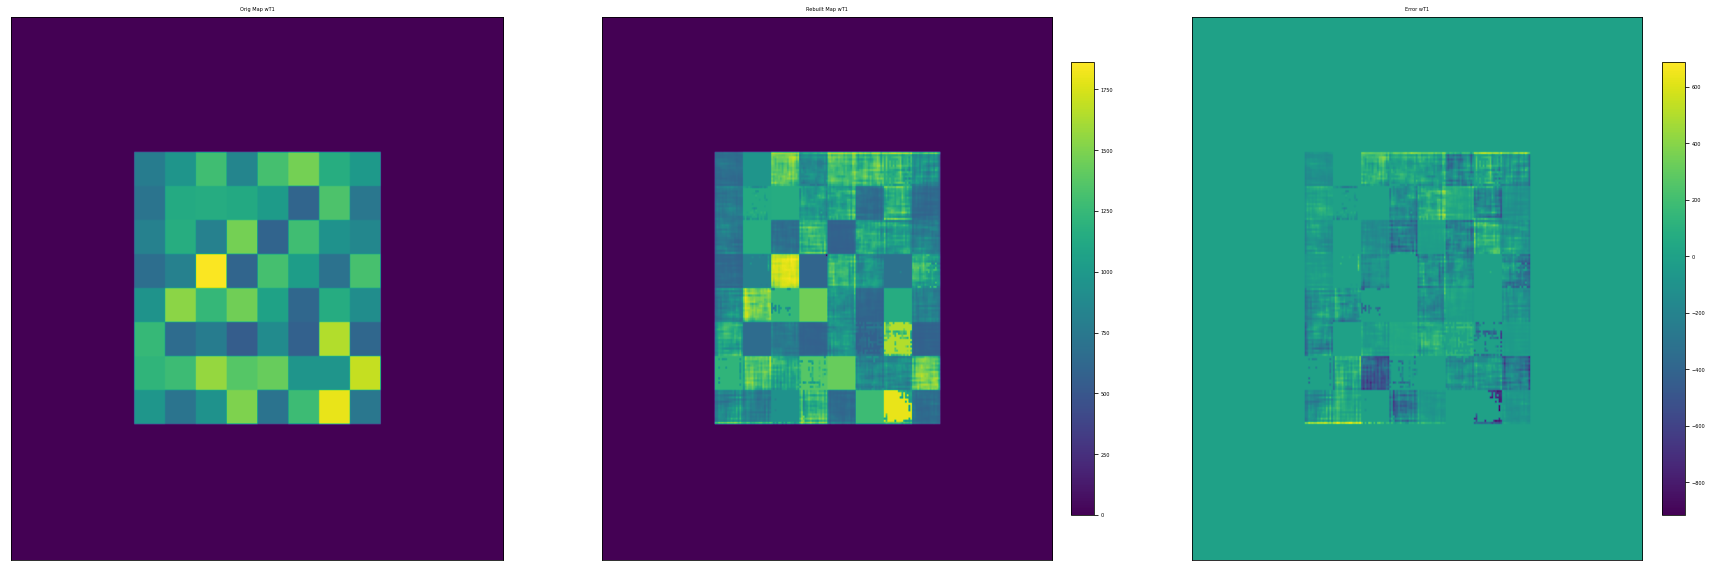

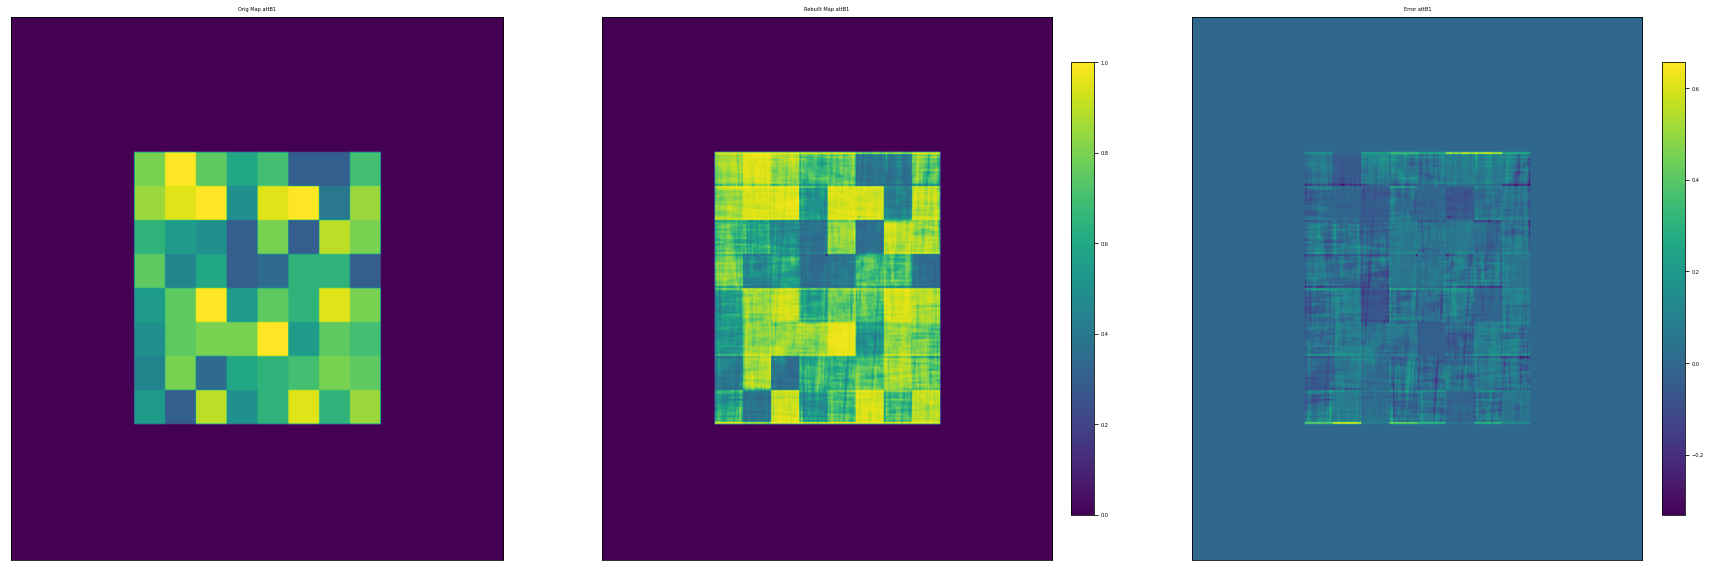

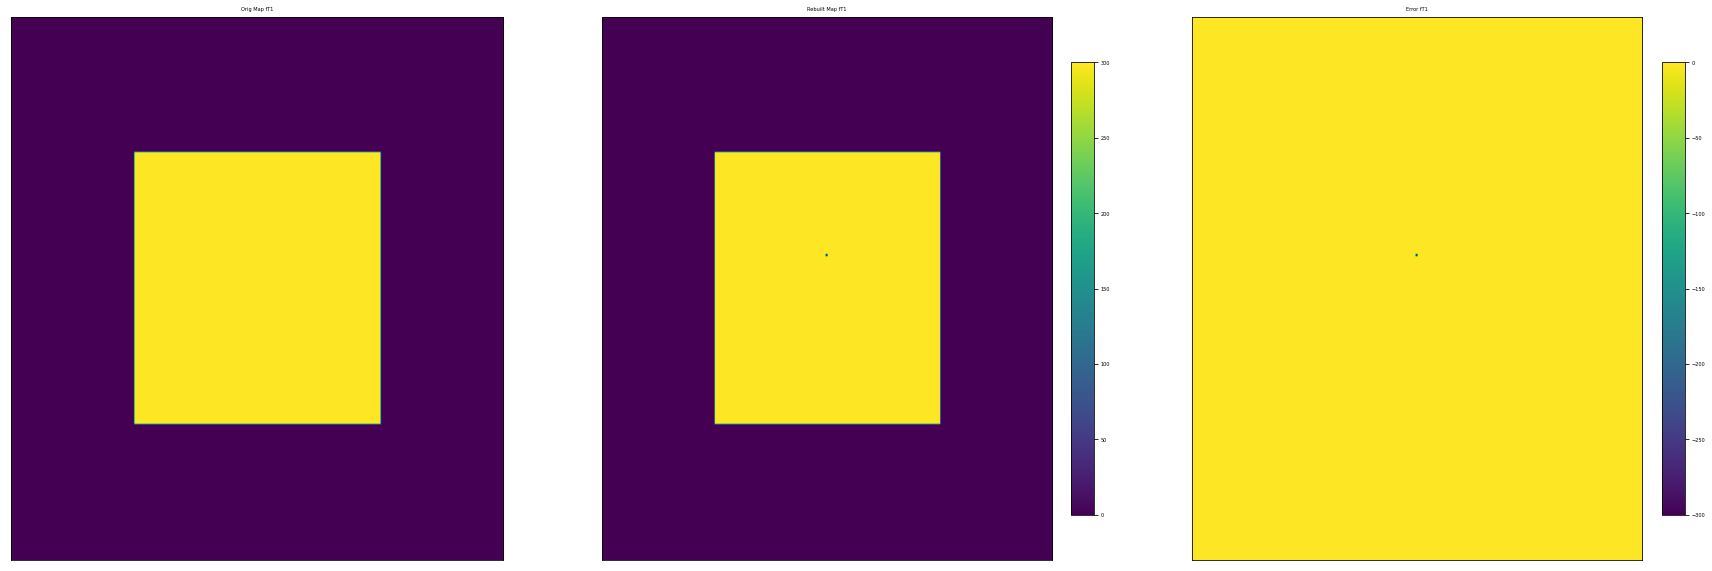

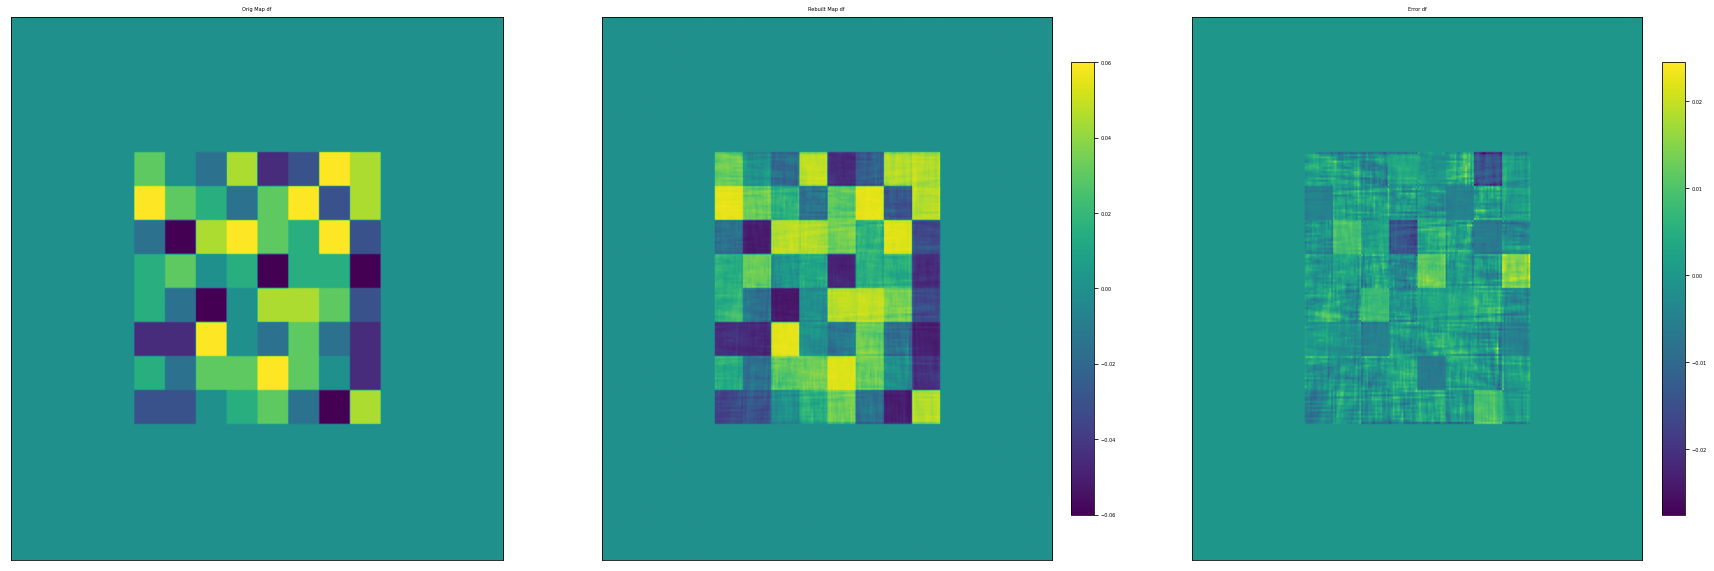

In [84]:

compare_paramMaps(m.paramMap, all_maps_adj[0][0], m.mask > 0, all_maps_adj[0][1] > 0,adj_wT1=True,fat_threshold=0.7,proj_on_mask1=True)

In [85]:
pixel=(70,110)
current_params={}

In [86]:
for k in m.paramMap.keys():
    if k not in ["wT2","fT2"]:
        current_params[k]=makevol(m.paramMap[k],m.mask>0)[pixel[0],pixel[1]]
    
print(current_params)

{'wT1': 1290.0, 'fT1': 300.0, 'attB1': 0.75, 'df': -0.015, 'ff': 0.15000000000000002}


In [87]:
retrieved_params_read={}
for k in all_maps_adj[0][0].keys():
    if k not in ["wT2","fT2"]:
        retrieved_params_read[k]=makevol(all_maps_adj[0][0][k],all_maps_adj[0][1]>0)[pixel[0],pixel[1]]
    
print(retrieved_params_read)

{'wT1': 1270.8878, 'fT1': 300.00162, 'attB1': 0.84193933, 'df': -0.02185057, 'ff': 0.12369144}


In [55]:
current_params_array=np.expand_dims(np.array(list(current_params.values())),axis=0)

In [56]:
closest_index=np.argmin(np.linalg.norm((Y_TF-current_params_array),axis=-1))

In [34]:
signal.shape

(323190, 175)

In [35]:
NN_search.paramDict["input_scaler"]

In [36]:
signal=volumes[:,pixel[0],pixel[1]]
#signal/=np.linalg.norm(signal)

real_signal=signal.real.T
imag_signal=signal.imag.T
#real_signal=real_signal/np.linalg.norm(real_signal)
#imag_signal=imag_signal/np.linalg.norm(imag_signal)

signal = np.concatenate((real_signal, imag_signal), axis=-1)
#signal=signal/np.linalg.norm(signal)
if NN_search.paramDict["input_scaler"] is not None:
    signal=NN_search.paramDict["input_scaler"].transform(signal.reshape(1,-1))
else:
    signal=signal.reshape(1,-1)
    
retrieved_params=NN_search.paramDict["output_scaler"].inverse_transform(NN_search.paramDict["model"].predict(signal))
print(retrieved_params)

[[1.5502242e+03 3.0000137e+02 3.5705879e-01 5.2727893e-02 6.3044852e-01]]


In [37]:
current_params_retrieved_array=np.expand_dims(retrieved_params[0],axis=0)
closest_index_retrieved=np.argmin(np.linalg.norm((Y_TF-current_params_retrieved_array),axis=-1))

In [38]:
j=closest_index
print(Y_TF[j])
if NN_search.paramDict["input_scaler"] is not None:
    x=NN_search.paramDict["input_scaler"].transform(X_TF[j].reshape(1,-1))
else:
    x=X_TF[j].reshape(1,-1)
    
NN_search.paramDict["output_scaler"].inverse_transform(NN_search.paramDict["model"].predict(x))

[1.26e+03 3.00e+02 3.00e-01 6.00e-02 7.00e-01]


array([[1.1903354e+03, 3.0000107e+02, 3.2669941e-01, 5.6306034e-02,
        7.0727915e-01]], dtype=float32)

In [39]:
k=closest_index_retrieved
print(Y_TF[k])
if NN_search.paramDict["input_scaler"] is not None:
    x_retrieved=NN_search.paramDict["input_scaler"].transform(X_TF[k].reshape(1,-1))
else:
    x_retrieved=X_TF[k].reshape(1,-1)
    
    NN_search.paramDict["output_scaler"].inverse_transform(NN_search.paramDict["model"].predict(x_retrieved))

[1.55e+03 3.00e+02 3.50e-01 6.00e-02 6.50e-01]


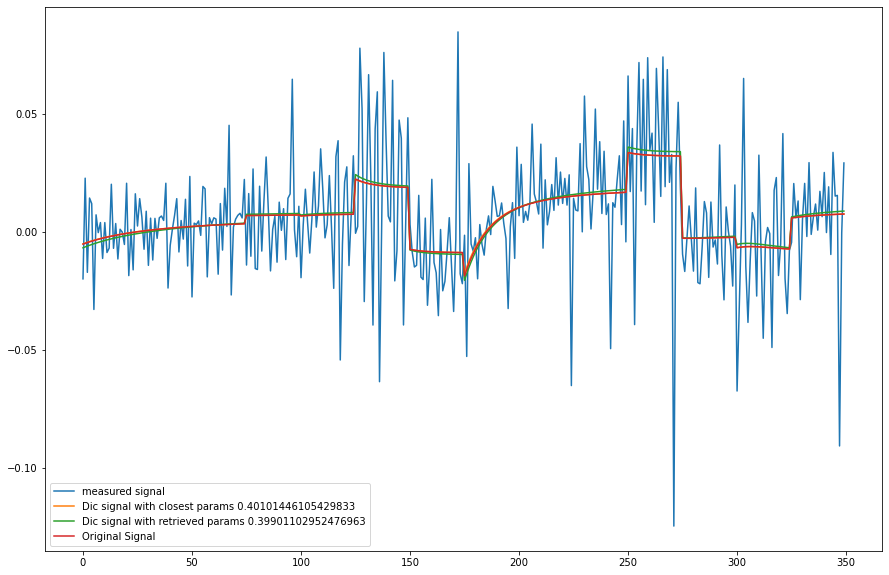

In [40]:
plt.figure(figsize=(15,10))
plt.plot(signal.T,label="measured signal")
plt.plot(x.T,label="Dic signal with closest params {}".format(np.corrcoef(x,signal)[0,1]))
plt.plot(x_retrieved.T,label="Dic signal with retrieved params {}".format(np.corrcoef(x_retrieved,signal)[0,1]))
plt.plot(np.concatenate([m.images_series[::8,pixel[0],pixel[1]].real,m.images_series[::8,pixel[0],pixel[1]].imag],axis=-1),label="Original Signal")
plt.legend()

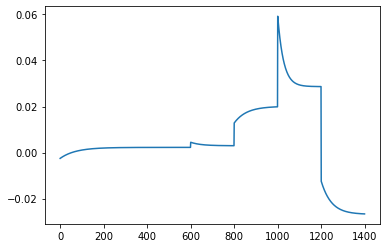

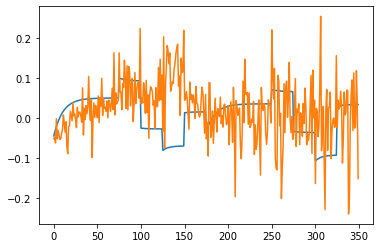

In [45]:
plt.plot(X_TF[j].reshape(1,-1).T)
plt.plot(np.concatenate((real_signal, imag_signal), axis=-1))

In [1]:
X_TF[j].reshape(1,-1)

NameError: name 'X_TF' is not defined

In [ ]:
NN_search.paramDict["input_scaler"].__dict__